In [1]:
import logging
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import math
import pandas as pd
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from collections import OrderedDict
import torch
import torch.nn as nn
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import pickle
from tqdm import tqdm_notebook as tqdm
import torchvision
import time
from collections import defaultdict
from torch.nn import CTCLoss
from Levenshtein import distance
import random
from torch.utils import data
from torch.utils.data import DataLoader

In [2]:
class ImageDataset(data.Dataset):
    """
    Dataset class for handwritten lines.

    Parameters
    ----------
    pickle_file : str
        Path to a dataset pickle file.
    meta : bool
        If True, meta data about files is provided.
    num_imgs : int, optional (default=-1)
        Choose only `num_imgs` imgs for processing. If set to -1, uses all available images.

    """

    def __init__(self, pickle_file, meta=False, num_imgs=-1):
        with open(pickle_file, 'rb') as f:
            dataset = pickle.load(f)
        self.reference_dataset = dataset
        self.num_imgs = num_imgs
        if (self.num_imgs > 0) and (self.num_imgs < len(self.reference_dataset)):
            inds = np.random.choice(np.arange(len(self.reference_dataset)),
                                    self.num_imgs, replace=False)
            self.reference_dataset = [self.reference_dataset[i] for i in inds]
        self.meta = meta

    def __getitem__(self, idx):
        data = self.reference_dataset[idx]
        #img = cv2.imread(data['img_path'], cv2.IMREAD_UNCHANGED) / 255.
        img = cv2.resize(cv2.cvtColor(cv2.imread(data['img_path']), cv2.COLOR_BGR2RGB), (442, 64)) / 255.
        img = torch.from_numpy(img).permute(2,0,1).float()
        text = data['description']
        width = data['width']
        height = data['height']

        if self.meta:
            return img, text, data, width, height
        else:
            return img, text

    def __len__(self):
        return len(self.reference_dataset)
    
class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index
        #self.alphabet = alphabet

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1
    
    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.LongTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.LongTensor [n]: length of each text.
        """

        length = []
        result = []
        for item in text:            
#             item = item.decode('utf-8','strict')
            length.append(len(item))
            r = []
            for char in item:
                index = self.dict[char]
                # result.append(index)
                r.append(index)
            result.append(r)
        
        max_len = 0
        for r in result:
            if len(r) > max_len:
                max_len = len(r)
        
        result_temp = []
        for r in result:
            for i in range(max_len - len(r)):
                r.append(0)
            result_temp.append(r)

        text = result_temp
        return (torch.LongTensor(text), torch.LongTensor(length))


    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.LongTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.LongTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.LongTensor([l]), raw=raw))
                index += l
            return texts

In [3]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output
    
class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0, 0]
        ss = [1, 1, 1, 1, 1, 1, 1, 2]
        nm = [16, 32, 128, 256, 512, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        convRelu(7, True)
        

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)
        
        # add log_softmax to converge output
        output = F.log_softmax(output, dim=2)

        return output


    def backward_hook(self, module, grad_input, grad_output):
        for g in grad_input:
            g[g != g] = 0   # replace all nan/inf in gradients to zero

In [4]:
def train_on_batch_rec(images, gt_text, model_crnn, ocr_loss, optimizer, device, batch_size, converter):

    model_crnn.train()
    
    pred_text = model_crnn(images.to(device))
    
    preds_size = torch.LongTensor([pred_text.size(0)] * batch_size)
    
    t_text, l_text = converter.encode(list(gt_text))
    
    loss = ocr_loss(pred_text, t_text, preds_size, l_text)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, decode_text = pred_text.max(2)
    decode_text = decode_text.transpose(1, 0).contiguous().view(-1)
    decode_text = converter.decode(decode_text.data, preds_size, raw=False)
    
    char_correct = 0
    total_char = 0
    for pred, gt in zip(decode_text, gt_text):
        for i, pred_char in enumerate(pred):
            if i<len(gt):
                if pred_char == gt[i]:
                    char_correct += 1
        total_char += len(gt)
            
    acc_char = (char_correct)/float(total_char)
    
    total_str = 0
    n_correct = 0
    cer = 0
    for pred, target in zip(decode_text, gt_text):
        if pred == target:
            n_correct += 1
        else:
            cer += distance(pred, target)/len(target)
        total_str+=1
            
    acc_str = (n_correct)/total_str
    cer = cer/total_str
    
    return (loss.item(), acc_char, acc_str, cer)

def val_on_batch_rec(images, gt_text, model_crnn, ocr_loss, device, batch_size, converter):

    model_crnn.eval()
    
    pred_text = model_crnn(images.to(device))
    
    preds_size = torch.LongTensor([pred_text.size(0)] * batch_size)
    
    t_text, l_text = converter.encode(list(gt_text))
    
    loss = ocr_loss(pred_text, t_text, preds_size, l_text)
    
    _, decode_text = pred_text.max(2)
    decode_text = decode_text.transpose(1, 0).contiguous().view(-1)
    decode_text = converter.decode(decode_text.data, preds_size, raw=False)
    
    char_correct = 0
    total_char = 0
    for pred, gt in zip(decode_text, gt_text):
        for i, pred_char in enumerate(pred):
            if i<len(gt):
                if pred_char == gt[i]:
                    char_correct += 1
        total_char += len(gt)
            
    acc_char = (char_correct)/float(total_char)
    
    total_str = 0
    n_correct = 0
    cer = 0
    for pred, target in zip(decode_text, gt_text):
        if pred == target:
            n_correct += 1
        else:
            cer += distance(pred, target)/len(target)
        total_str+=1
            
    acc_str = (n_correct)/total_str
    cer = cer/total_str
    
    _, preds = pred_text.max(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)
    raw_preds = converter.decode(preds.data, preds_size, raw=True)
    
    return (loss.item(), acc_char, acc_str, cer, decode_text[:5], gt_text[:5], raw_preds[:5])

In [5]:
pickle_path_train = '/home/storage/3020/KrivorotovI/db/HKR/datasets/train.pkl'
pickle_path_val = '/home/storage/3020/KrivorotovI/db/HKR/datasets/val.pkl'
with open(pickle_path_train, 'rb') as f:
    full_dataset = pickle.load(f)
alphabet = ''
for example in full_dataset:
    alphabet += example['description']
alphabet = list(set(alphabet))
alphabet =''.join(alphabet)
len(alphabet)

79

In [6]:
imgH = 32 # the height of the input image to network
imgW = 100 # the width of the input image to network
nh = 256 # size of the lstm hidden state
nc = 3
nclass = len(alphabet)+1
batch_size = 64

In [7]:
device = torch.device("cuda:7")
converter = strLabelConverter(alphabet)
net = CRNN(imgH, nc, nclass, nh)
net.to(device)
ocr_loss = CTCLoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.0001)
train_dataset = ImageDataset(pickle_path_train, num_imgs=-1)
val_dataset = ImageDataset(pickle_path_val, num_imgs=-1)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)

torch.Size([64, 3, 64, 442])
чувствую солидарность,


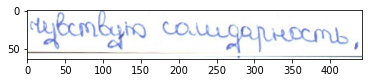

In [8]:
for imgs, text in train_dataloader:
    print(imgs.shape)
    plt.imshow(imgs[0].permute(1,2,0))
    print(text[0])
    break

In [9]:
ep = 100

train_loss = []
train_acc_char = []
train_acc_str = []
train_cer = []

val_loss = []
val_acc_char = []
val_acc_str = []
val_cer = []

best_str_acc = 0

for epoch in range(ep):
    train_epoch_loss = []
    
    train_epoch_acc_char = []
    train_epoch_acc_str = []
    train_epoch_cer = []
    
    with tqdm(total = len(train_dataloader), ncols='100%') as bar_train:
        for i, (images, gt_text) in enumerate(train_dataloader):

            results = train_on_batch_rec(images, gt_text, net, ocr_loss, optimizer, device, batch_size, converter)
            loss, acc_char, acc_str, cer = results
            
            train_epoch_loss.append(loss)
            train_epoch_acc_char.append(acc_char)
            train_epoch_acc_str.append(acc_str)
            train_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Train loss: {np.mean(train_epoch_loss):.4f}.\
            Acc char: {np.mean(train_epoch_acc_char):.4f}.\
            Acc str: {np.mean(train_epoch_acc_str):.4f}.\
            CER: {np.mean(train_epoch_cer):.4f}."
            bar_train.set_description(printed_data)
            bar_train.update(1)
            
    train_loss.append(np.mean(train_epoch_loss))
    
    train_acc_char.append(np.mean(train_epoch_acc_char))
    train_acc_str.append(np.mean(train_epoch_acc_str))
    train_cer.append(np.mean(train_epoch_cer))
    
    
    val_epoch_loss = []
    
    val_epoch_acc_char = []
    val_epoch_acc_str = []
    val_epoch_cer = []
    
    with tqdm(total = len(val_dataloader), ncols='100%') as bar_val:
        for i, (images, gt_text) in enumerate(val_dataloader):

            results = val_on_batch_rec(images, gt_text, net, ocr_loss, device, batch_size, converter)
            loss, acc_char, acc_str, cer, decode_text, gt_text, raw_preds = results
            
            val_epoch_loss.append(loss)
            val_epoch_acc_char.append(acc_char)
            val_epoch_acc_str.append(acc_str)
            val_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Val loss: {np.mean(val_epoch_loss):.4f}.\
            Acc char: {np.mean(val_epoch_acc_char):.4f}.\
            Acc str: {np.mean(val_epoch_acc_str):.4f}.\
            CER: {np.mean(val_epoch_cer):.4f}."
            bar_val.set_description(printed_data)
            bar_val.update(1)
        
    val_loss.append(np.mean(val_epoch_loss))
    
    val_acc_char.append(np.mean(val_epoch_acc_char))
    val_acc_str.append(np.mean(val_epoch_acc_str))
    val_cer.append(np.mean(val_epoch_cer))
    
    print('Lr now:', optimizer.param_groups[0]['lr'])

    for raw_pred, pred, gt in zip(raw_preds, decode_text, gt_text):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt)) 
    
    if epoch == 40:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer.param_groups[0]['lr'])
        
    if epoch == 70:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer.param_groups[0]['lr'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Lr now: 0.0001
К------------------------------------------------------ => К                   , gt: Костанай            
------------------------------------------------------- =>                     , gt: раион               
К------------------------------------------------------ => К                   , gt: АЛМАТИНСКАЯ         
в------------------------------------------------------ => в                   , gt: и ворча, сосали     
К------------------------------------------------------ => К                   , gt: Актобе              



Lr now: 0.0001
А---------------кк-------тт-------о-------бб--------е-е => Актобее             , gt: Актобе              
Я--------  -----------------вв----------у------и------ь => Я вуиь              , gt: яд другим           
П-----------аа-----в-------л----о--дд-----ааа---------- => Павлода             , gt: Павлодар            
З----е-т------я--тт---  --------м------л--е-ее---м----- => Зетят млеем         , gt: Летят шмели         
г------рр-------е-------л-----------------------н------ => грелн               , gt: гремит              



Lr now: 0.0001
в----з-----в--------в-----------д---в---в----в--------, => взввдввв,           , gt: Его живит,          
К--------о-------------------в-------------а---------я- => Ковая               , gt: Костанай            
Ш-------в-------в------о---я----к-----е---р-----р-----з => Шввоякеррз          , gt: Шымкент             
А-----в-------в----------------а---------в----в-------- => Аввавв              , gt: АСТАНА              
в---вв-в--в-в---------а-----а--ввв--в---в--в--в---вввв- => ввввваавввввв       , gt: Они, толкаясь       



Lr now: 0.0001
Е----------о-   ----------ж------ии--вв---ии----т-----, => Ео живит,           , gt: Его живит,          
К-----у---д--а---?....-..  --З---аа--чч---е---м---?..-. => Куда?.. Зачем?..    , gt: Куда?.. Зачем?..    
А--------------------лл----------г-----------а--------- => Алга                , gt: Алга                
в-----  ---п---рр------с----а--й-  --о--п---рр-а--в-е-- => в прсай оправе      , gt: в простой оправе    
И-----------,,  ------нн-----ии-----ч-----ее---гг----о- => И, ничего           , gt: И, ничего           



Lr now: 0.0001
А------------лл---------м----------а------т------ыыы--- => Алматы              , gt: Алматы              
Р----е--бб----я---т-- -----у--ж------е-  -------н----е- => Ребят уже не        , gt: Ребят уже не        
б-а--п--о--д-нн-оо-----К-аа--а--х---а-а--н--с-к--а---я- => баподно-Каахаанская , gt: Западно-Казахстанская
п----------оо-----гг-----о------дд--------а-----------, => погода,             , gt: погода,             
Ш----------е----л------ы---н-----а----ии------х-----а-- => Шелынаиха           , gt: Шемонаиха           



Lr now: 0.0001
р-------а- -сс-с-т-----и-----л---а-----т--т---сс---я--- => ра сстилаттся       , gt: расстилаются        
н---а---м--     --н---а--сс-л--аа--д--ии-т----ь--с---я- => нам насладиться     , gt: нам насладиться     
в----е--л--очч--и--н----о--й-   ---о   ---дд-о--мл---а- => велочиной о домла   , gt: величиной с дома    
А--------------Л--------М-----------------Т-----Ы------ => АЛМТЫ               , gt: АЛМАТЫ              
У-----------------а---------нл---------я------------я-- => Уанляя              , gt: удаляя              



Lr now: 0.0001
д--------------к--------г-------------аа------------у-- => дкгау               , gt: Актау               
н--о--  --т---ы--   ---н-е--  --е-н--и--р-е--ии--л--я-- => но ты не ениреиля   , gt: но ты не снизошла.  
о------------пп----------ы------------т---------------- => опыт                , gt: опыт                
н--о-  -т---ы-- --н--е--  -с-н--и---з-о-------л---а---. => но ты не снизола.   , gt: но ты не снизошла.  
А-------л---мм----а----р------а----н----и---к--а-----я- => Алмараникая         , gt: Алматинская         



Lr now: 0.0001
и--хх  -н--а--с-лее-д-с-т--вв-е-н-н-ы---й   ---е--и-тт- => их наследственный еит, gt: их наследственный щит
Г------д--ее-   ----------т------и---шш----ии---н---аа- => Где тишина          , gt: Где тишина          
У------в---ы--ы-----------ы----л----а-----р---а---д---- => Увыыыларад          , gt: Кызылорда           
д-----------жж----------иии---------ии-------т------уу- => джииту              , gt: джигиту             
Т---о--ль--н-о-  ---в-е-р--с-т--ы-  -п-о--л----а--т---я => Тольно версты полатя, gt: Только версты полосаты



Lr now: 0.0001
Ж---------------е-----сс---т--------н------о--------йй- => Жестной             , gt: Жестокой            
К------иии----р---гг------иии-----зз----иии------я----- => Киргизия            , gt: Киргизия            
П----------р----ии-----о------зз--е----р---с----к------ => Приозерск           , gt: Приозерск           
К-----о----к-----ш---шш------е---тт---------а--------у- => Кокшшетау           , gt: Кокшетау            
Н------а--   ----------З----а---к-----а---т--------е--- => На Закате           , gt: на закате           



Lr now: 0.0001
А---------л----мм-----а---т-----ии--н---с--к----а----я- => Алматинская         , gt: Алматинская         
З--а-п--ааа-д--н--о---К--а-з-а--х--сст--а--н--сс-к--а-- => Западно-Казахстанска, gt: Западно-Казахстанская
О-----пп------я---т---ь---,,  ----с--тт---о--гг---о---с => Опять, стогос       , gt: Опять, стога        
и--------рр----е----м-----м---------иии----тт---------. => иреммит.            , gt: гремит.             
С-----   ------т-----рр-----у---х----о---йй-   ----и--- => С трухой и          , gt: С трухой и          



Lr now: 0.0001
З--а--п--а--д-н-о----КК--а--з-а--х-сстт---а--н--сккаа-я => Западно-Казахстанская, gt: Западно-Казахстанская
с---н---у----юю--т----  --п---уу-н------ц-о---в--ы---ее => снуют пунцовые      , gt: Снуют пунцовые      
Т---о---л--ч--к---а----е----и--   ----к---р--оо--в--ь-, => Толчкаеи кровь,     , gt: Толчками кровь,     
Д-----------о------лл------и-----н--------к------аа---- => Долинка             , gt: Долинка             
к--   --м---а---м--е--,  -х---о--д-н--о---н--и---м---и- => к маме, ходноними   , gt: к маме, жадно пили  



Lr now: 0.0001
И--- --ж--------у--н--ь-   -----п---о---б----л----е---, => И жунь побле,       , gt: И жизнь поболее,    
К----о--н---ьь-   --------д-о--гг-о---н---ии---т------, => Конь догонит,       , gt: Конь догонит,       
п----р--ее---д--  ----аа---н---а-----л--о--ее---т-----, => пред аналоет,       , gt: пред аналоем,       
А--------------с-----тт----------а-------нн--------а--- => Астана              , gt: Астана              
О------т----  ------ККК------а---с--п---------я--  --и- => От Каспя и          , gt: От Каспия и         


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Lr now: 0.0001
м-------о--р----я--к--ии-  ----г---л---я---д----я---т-- => моряки глядят       , gt: моряки глядят       
л-------------------------------д-------а------------,, => лда,                , gt: иногда,             
Г--------д----е---  ------------н------о---чччч-----ьь- => Где ночь            , gt: Где ночь            
Т----------------е------к------еее-----р---------и----- => Текери              , gt: Текели              
х-----------ллл-----а-------дд----нн------ы---------йй- => хладный             , gt: хладный             



Lr now: 0.0001
м---о--ч--нн--о  ---о-с-т---оа-бв--и--т--ьь--г--ор---я- => мочно остоабвитьгоря, gt: можно составить город
м-------оо---йй    --------я----м----------щ--ии---к--, => мой ямщик,          , gt: мой ямщик,          
А-----------бб-----х-----а-----зз-------иии-------я---- => Абхазия             , gt: Абхазия             
С-----------т------------р--------ии---------н-------я- => Стриня              , gt: Страна              
Г-------аа-----------т----е----л---ее----г-----а-----и- => Гателегаи           , gt: за телегои          



Lr now: 0.0001
К-----------иии----рр---гг---иии------з-----иии----я--- => Киргизия            , gt: Киргизия            
Л-----ь--е--тт--    ------п---е--ч--а-----л--ьь-нн---о- => Льет печально       , gt: Льет печально       
с--------л--------уу------ч------нн--------о----------- => случно              , gt: скучнои             
А------------------ккк------------сссс------------уу--- => Аксу                , gt: Аксу                
Т------ы--  ---о--т----д-а----л--а-   -----сс-в--о---юю => Ты отдала свою      , gt: Ты отдала свою      



Lr now: 0.0001
н-----е-   --------и---с--п-----у--гг--а--ее---т------, => не испугает,        , gt: не испугает,        
О--нн---и-,,  --п---р--и--жж------а--вв--шш----ии--с--ь => Они, прижавшись     , gt: Они, прижавшись     
п-----е---р----е-----н----о-----и--------в----а----л--. => переноивал.         , gt: переночевал.        
К----------------аа-----м------к----е----------т------- => Камкет              , gt: Шымкент             
Н--о-  -ч--т---о-   --н---а--ш---   ---д-е--л--аа-т---ь => Но что наш делать   , gt: Но что нам делать   



Lr now: 0.0001
Я--   ---в--х--о--д-ии--л--   ----в---м---е--сс-т----о- => Я входил вместо     , gt: Я входил вместо     
К-------------о---сс----т-------а-----н-----а------йй-- => Костанай            , gt: Костанай            
К----а---р---а---г---а---н---дд-ии--н---сс--к--аа----я- => Карагандинская      , gt: Карагандинская      
м-------о--рр---я--к---у--,,  ------п-----о----я---т--. => моряку, поят.       , gt: моряку, горят.      
И---   -----с--мм---а---х-н----у--л-  ---б--ы--  ---я-. => И смахнул бы я.     , gt: И смахнул бы я.     



Lr now: 0.0001
Д-------о--гг--о----н------ии--  ---------------е-----, => Догони е,           , gt: Догони же,          
К---------а------зз---а-----х----с---т--------а-----н-- => Казахстан           , gt: Казахстан           
У---------к-------рр-------а------и-------нн-------а--- => Украина             , gt: Украина             
Я----------    -----------вв------е--р---о---------юю-- => Я верою             , gt: Я верю              
Я--------    -------к-----р-----е----п------к------оо-- => Я крепко            , gt: Я крепко            



Lr now: 0.0001
В--О--С-Т-О-ЧЧ-Н-ОО----КК--А-З--А-Х--С-Т-АА-Н--С-К--А-Я => ВОСТОЧНО-КАЗАХСТАНСКАЯ, gt: ВОСТОЧНО-КАЗАХСТАНСКАЯ
п----------оо-----гг-----о------ддд-------а----------,, => погода,             , gt: погода,             
К---------ии----рр-----г-----ииии------з----иии---яя--- => Киргизия            , gt: Киргизия            
д-----л---я- --н---аа---с   ---с--а----д--ии-т----сс--я => для нас садится     , gt: для нас садится     
З----аа--вв--т-р----а-  --к-  ---л----и---н----оо----й- => Завтра к линой      , gt: Завтра к милой      



Lr now: 0.0001
А-----------с---------т------а-------нн----------а----- => Астана              , gt: АСТАНА              
Т-------ы----,,  ---мм----ии--лл--а---я-,,  -т-----ы--- => Ты, милая, ты       , gt: Ты, милая, ты       
С-е--в-е-т-нн-о-----К--а--зз-а--х-ссст--а--н-сс-к-аа--я => Севетно-Казахстанская, gt: Северно Казахстанская
Д---------------о-----лл----ииии--нн-----к--------а---- => Долинка             , gt: Долинка             
г---о--р--е---стт--н---о---йй-  ---д-ее--мм----л--ее--, => горестной демле,    , gt: горестной земле,    



Lr now: 0.0001
Р-------------о------с-----сс---------иии-------я------ => Россия              , gt: Россия              
в--   --зз-а-рр--ь-сс--л--я---х-  -----у--к--р-----п--. => в зарьслях укрп.    , gt: в зарослях укроп.   
С---к---у-чч--н---о----,, -гг--р----у--с--тт-----н---о- => Скучно, грустно     , gt: Скучно, грустно     
С---т---о--гг   ----п---р--ии--нн---ии---м---а---е--т-- => Стог принимает      , gt: Стог принимает      
А----------------е------------------------е-------р---- => Аеер                , gt: Ленгер              



Lr now: 0.0001
ч-еерр-нн--о--и   -т----о---л-ьь--ю  --г--у--м---н---а- => чернои толью гумна  , gt: чернои толью гумна  
З--а--п--а--д-нн-о-----ККК-ааа--з-аа-хх-ссст-а-н--с-каа => Западно-Казахстанска, gt: Западно-Казахстанская
Н---е  --з---н--а----ю-,,  --г-д-ее  --п--р--ии----ю--т => Не знаю, где приют  , gt: Не знаю, где приют  
А-------тт-----ыы----р---а-----у--сс---кк----а------я-- => Атырауская          , gt: Атырауская          
А-----------К--------Т--------О---------Б---------Е---- => АКТОБЕ              , gt: АКТОБЕ              



Lr now: 0.0001
в--ы--ж---жж--е-н--н---ы--хх    -----ссо-л-е--н--ии--йй => выжженных солений   , gt: выжженных селений   
П------е-тт---р----о--п---а----в----л--о---в---сс--к--- => Петропавловск       , gt: Петропавловск       
М---------------о-----лл-----д----а------т--------х---- => Молдатх             , gt: Молдавия            
Р-----ррр------ее---------мм-------е-------л---------—- => Рремел—             , gt: гремел —            
К-----а---р---а---гг--а--нн---дд--и---н--ссскк--а----я- => Карагандинская      , gt: Карагандинская      



Lr now: 0.0001
с-------о--л---дд-о-сстт--ьь  --п---р--о---ш---л--а---! => солдость прошла!    , gt: молодость прошла!   
У---------к-------р------а-------и-------н--------а---- => Украина             , gt: Украина             
У---сс-тт---ь-------К--аа--м---е-н---о-гг-о--р--с--к--- => Усть-Каменогорск    , gt: Усть-Каменогорск    
Г---л----у--ш-----ьь-   ----и--  --с---н---ее---г-----… => Глушь и снег…       , gt: Глушь и снег..      
В----ос-т--о-ч-нноо---ККК-а-ззаа-х-сст--а--н-ссккаа--я- => Восточно-Казахстанская, gt: Восточно-Казахстанская



Lr now: 0.0001
м----ы---у-ч-е--й-   -------и-   --сс-в--ы---у-н--о--йй => мыучей и свыуной    , gt: могучей и свободной 
Ю----ж--н-о-------К-а-зз-а--хх--сс-т----я-н--с-к--а---я => Южно-Казахстянская  , gt: Южно-Казахстанская  
н---------а---------в------с---е----------дд-------т--- => навседт             , gt: навсегда            
И------------------ш---------аа-------кк-------а-----,, => Ишака,              , gt: Ишака,              
с----в--о-е--й-   -----с--о--в--еерр---шш------и--т---, => своей совершит,     , gt: свой совершит,      



Lr now: 0.0001
К-----а---к---   ---н---е--к---оо-г--д--а----  ----в--. => Как некогда в.      , gt: Как некогда в       
о--------пп-------------яя----------н-----------ьь----- => опянь               , gt: опять               
А---------------------м-----------------аа----------уу- => Амау                , gt: Актау               
А-------------кк-------т-----р-------а-----------уу---- => Актрау              , gt: Актау               
А------лл---т-----к--е--бб---и---н----сс-кк---иа----яя- => Алткебинскиая       , gt: Актюбинская         



Lr now: 0.0001
н-----е----у----дд--е---рр------ж------ииии---мм----оо- => неудержимо          , gt: неудержимо          
Н------------и---   --------о---гг----н-----------яя--, => Ни огня,            , gt: Ни огня,            
Ж---------а---п--я---б---ы----л---сс--к----аа-------яя- => Жапябылская         , gt: Жамбылская          
г-----рр---ее-----м-------е-------л----   ----------——— => гремел —            , gt: гремел —            
С-  --в---ы----с-с--тт---ы---  -л--е--дд--и--ии--к---а- => С выссты ледиика    , gt: С высоты ледника    



Lr now: 0.0001
Т----о--лл-чч--к---а----м----ии-   -----к-рр---о--в--ь, => Толчками кровь,     , gt: Толчками кровь,     
К-------аа---р-----аа----бб---а-------лл---ы-------к--- => Карабалык           , gt: Карабалык           
Г--д-ее-  ---------в------л-   -------пп--о--ж----а-рр- => Где вл пожар        , gt: Где выл пожар —     
К----------о---к-----шш------ее---тт-------а--------у-- => Кокшетау            , gt: Кокшетау            
А--------к----мм-----о---лл---иии-н----ссс-кк---а----яя => Акмолинская         , gt: Акмолинская         



Lr now: 0.0001
Х--------рр--------о--------м-------т------а--------уу- => Хромтау             , gt: Хромтау             
н--аа--н---е-сс-е-н--н--ы---е-  ----вв--о-йй--н---о--й- => нанесенные войной   , gt: нанесенные войной   
Н---------о--   ------------ж-------иии-----в----ы----- => Но живы             , gt: Но живы             
К----о---мм----уу--??   ----Л-----ю--б--оо---мм-----у-- => Кому? Любому        , gt: Кому? Любому,       
Г-------дд--е--   --------тт----------а------н-----к--- => Где танк            , gt: Где танк            



Lr now: 0.0001
с-----т---рр-------ее------к--------о---з------ыы------ => стрекозы            , gt: стрекозы            
З----а---вв--т----рр--а----,,  ---Н---ии---н----а-----, => Завтра, Нина,       , gt: Завтра, Нина,       
н---а--д--е-вв-а--л-  --н--аа-  --се-бб-яя-  -ч--т---о. => надевал на себя что., gt: надевал на себя что 
А---------Б-------Х------А---------З-----И----------ЯЯ- => АБХАЗИЯ             , gt: Абхазия             
З-аа-п--а-дд-нн--о----КК-а--з-а--хх-сст--а--н-сскк-а--я => Западно-Казахстанская, gt: Западно-Казахстанская



Lr now: 0.0001
А-------------тт---------ыы------рр-------а---------уу- => Атырау              , gt: Атырау              
Т--------------уу--рр----к---ее--сс--т------а----н----- => Туркестан           , gt: Туркестан           
И---  -мм--ыы-   --л--о--м---а--е--м--   --р--у--к--и-, => И мы ломаем руки,   , gt: И мы ломаем руки,   
А------------Л-------М------------А-------Т-------Ы---- => АЛМАТЫ              , gt: АЛМАТЫ              
Я---------    ----з---а-----бб---уу----дд----уу--сс--ь- => Я забудусь          , gt: Я забудусь          



Lr now: 0.0001
А-----------кк--------р-----с-----------инн-------и---- => Акрсини             , gt: Украина             
А---------------------------и------гг-------а----н----- => Аиган               , gt: джигит              
О-----с--уу-жж------д--е-нн--ыы-    ---и----д--тт----кя => Осуждены идткя      , gt: Осуждены идти       
В----   ---с--о--к-рр--о---в--и------щщ--н----а----ц-е- => В сокровищнаце      , gt: В сокровищнице      
м-----------о--   --------о----п-----------я-----тт--ьь => мо опять            , gt: но опять            



Lr now: 0.0001
т-------вв--о-е--ййй   ------г---о---р---д--ы---нн--ее- => твоей гордыне       , gt: твоей гордыне       
и--   ---т---ее--н----ии--   ----ч---у---в--с--т--в-,,- => и тени чувств,      , gt: И тени чувств,      
А----------К------------Т-------О---------Б---------Е-- => АКТОБЕ              , gt: АКТОБЕ              
О----п----я---тт-----ь-   ------п----а---л--н------ы--- => Опять палны         , gt: Опять полны         
д----л---я-   ---н---а--сс-   ---ссаа--д-и--й -сс-я--,, => для нас садий ся,   , gt: для нас садится,    



Lr now: 0.0001
х---------------------лл------е---------------бб----,,, => хлеб,               , gt: хлеб,               
Г--------уу---л------ы--------шш-------аа-------т------ => Гулышат             , gt: Гульшат             
А------------л--ммм---а---тт---иии--н---ссс-к---а----я- => Алматинская         , gt: Алматинская         
П------е--т---рр----о--п---аа----в---л--о---вв--с---к-- => Петропавловск       , gt: Петропавловск       
д-----------о---   -------зз---аа---хх--оо---дд----аа-- => до захода           , gt: до захода           



Lr now: 0.0001
у------   ------к-----а-----м-------ии----н-----а-----? => у камина?           , gt: у камина,           
Ч---тт----о-  ---в--р-ее--м-е--я-  ---л-ее--ч---и--т--- => Что времея лечит    , gt: Что время лечит     
п---ы---л--ь  -с  -н--ии--хх- -к--р--ыы---лл--о---м---; => пыль с них крылом;  , gt: пыль с них крылом;  
К--------И-------Р-----Г-----И-------З----ИИ--------Я-- => КИРГИЗИЯ            , gt: КИРГИЗИЯ            
к-----------л---ее-----ввв----е----рр---------а-------. => клевера.            , gt: клевера.            



Lr now: 0.0001
п---р--е--дд-    -----аа--н---аа----л---о--е----мм----, => пред аналоем,       , gt: пред аналоем,       
П-----о--п---о---д--а----ю--т----сс-яя    --о--д--н--ее => Поподаются одне     , gt: Попадаются одне     
К---------а------з-----а-----х----с-----т-----а-----н-- => Казахстан           , gt: Казахстан           
н------е--   -----и---сс--п-----у--гг--а---е--тт------, => не испугает,        , gt: не испугает,        
Т-----о-  ссеерр-дд-е--ч-н---а---я-   -т----о-сс-к--аа- => То сердечная тоска  , gt: То сердечная тоска  



Lr now: 0.0001
Т--------а----л-----д---ы----к----о--рр---г---а----нн-- => Талдыкорган         , gt: Талдыкорган         
С---евввее-р--о----КК--ааззаа-х--с-т---а--нн-сскк--а--я => Северо-Казахстанская, gt: Северо-Казахстанская
н--оо  -т---ыы-  --н--е-  --о-г--л--я-нн-уу-лл-а--ссьь, => но ты не оглянулась,, gt: но ты не оглянулась,
У-----з---б---е---кк----ии-----сс--тт-------а-----н---- => Узбекистан          , gt: Узбекистан          
д--------жж----------иии-----г---иии-----т----------!-- => джигит!             , gt: джигит!             



Lr now: 0.0001
А-----------сс-----тт-------------а------н----------а-- => Астана              , gt: Астана              
А------тт------ыы-----р-----а-----у--сс--кк---аа-----я- => Атырауская          , gt: Атырауская          
Т-------у--р---к---и--сс-тт---аа---н--сс--к----а-----я- => Туркистанская       , gt: Туркистанская       
П-----ее-тт---рр----о--п---а----в--лл--о---вв--с--кк--- => Петропавловск       , gt: Петропавловск       
Л----ии-ш--ь   ---б--ы-   -н--е   --ппрр-о--сст-ии-тт-ь => Лишь бы не простить , gt: Лишь бы не простить 



Lr now: 0.0001
Т-------а------к---   ------------в----е-----к--------- => Так век             , gt: Так век             
С----------т---------рр------аа-------нн----------а---- => Страна              , gt: Страна              
ЗЗ-аа-п-аа-д-н--о  ---КК--азз-а-хх-сстт--а-нн-сс-к-а--я => Западно Казахстанская, gt: Западно Казахстанская
в--х-о-д--и--л--а-  --ж----а-жж---д-аа  --мм-е-сс-т--ии => входила жажда мести , gt: входила жажда мести 
А---------йй----т-------ее---к-----е-   ----б------а--- => Айтеке ба           , gt: Айтеке би           



Lr now: 0.0001
П-----------о------б----е-----л-----е-----л------ииии-- => Побелели            , gt: побелели            
б--е--с-п--о---е--зз-н--ы--   ----м---о---с--ь--бб--ыы- => беспоезны мосьбы    , gt: бесполезны мольбы   
А-----------------т-------ы---------р-------а-----уу--- => Атырау              , gt: АТЫРАУ              
т---------------------ее--------бб----------я--------,, => тебя,               , gt: тебя,               
ч---у-в-сстт--в--у--ю-  --с-о-лл-ии-д-а--н--н-о-сстт-ьь => чувствую солиданность, gt: чувствую солидарность



Lr now: 0.0001
б----ее-сс-с---м---е-р--т--нии-  ----с-т--ии--л--а--м-- => бессмертни стилам   , gt: бессмертными стихами
Н-------е-   ------ --в------м-----е----с---тт-------е- => Не  вместе          , gt: Не. вместе          
М--------------о------л----д-----аа----вв----ии-----я-- => Молдавия            , gt: Молдавия            
К--------о---с--т----аа---н---а---йй---сс-кк---аа----я- => Костанайская        , gt: Костанайская        
К--------а---р-----а-----бб---а--------лл--ы------кк--- => Карабалык           , gt: Карабалык           
Lr now: 1e-05



Lr now: 1e-05
н--аа--дд-е-в---а--л-  -н--а-  с-ее--б--я-  чч---т----о => надевал на себя что , gt: надевал на себя что 
м-------о-----й-   -------я----л---------щ--ии---к----- => мой ялщик           , gt: мой ямцик           
И--------  --ж----------е--нн--------у------и---к-----, => И женуик,           , gt: И женщина,          
к------а---к---    -----сс----нн----о---вв--а------лл-- => как сновал          , gt: как сеновал         
К-------------------у-----------п------а-----------о--- => Купао               , gt: Скучно              



Lr now: 1e-05
У----с-тт-ь----ККК---аа--м----е--нн--оо-г--оо-р---с--к- => Усть-Каменогорск    , gt: УСТЬ-КАМЕНОГОРСК    
и--  ------с-с--к--а---л--о----в-   ---н---а-сс-т---ь-, => и сскалов насть,    , gt: и оскалив пасть,    
о-------тт----------с-----тт-----------аа-----------л-- => отстал              , gt: отстал              
А-----------------с-------Т--------а------н---------а-- => АсТана              , gt: АСТАНА              
Ю-----жж----н---а----я-   ---О---сс-ее--тт-----ии----я- => Южная Осетия        , gt: Южная Осетия        



Lr now: 1e-05
л-----------------юю--------дддд-------ииии-----------, => люди,               , gt: люди,               
К--------О-------К------Ш--------Е----т-----А--------у- => КОКШЕтАу            , gt: Кокшетау            
Р-----------------------------------з------------------ => Рз                  , gt: РК                  
о--б-е--д--а---л    ----ч-ее-р--тт-  --з--н---а--ее-т-- => обедал черт знает   , gt: обедал черт знает   
Д----рр-ее--м-----я--   --сс--м----оо---л--ь--н----у-л- => Дремя смольнул      , gt: Дремля смолкнул     



Lr now: 1e-05
З-----а---р-----и-----в------шш------иии-----с----ьь--, => Зарившись,          , gt: Зарывшись,          
с-   --к--ее--мм--   ---в--о-   ---ффр--рр---а--кк--е-, => с кем во фрраке,    , gt: с кем во фраке,     
Г----р----у-сс--т-----н--о--,,, ----НН----и--нн---а---: => Грустно, Нина:      , gt: Грустно, Нина:      
в--ы--жж--ж---е-н--н---ы--хх-   -----с-о-л-е--н--ии--йй => выжженных солений   , gt: выжженных селений   
А---------л---мм----а----т---иии---т----ссс--к--а----яя => Алматитская         , gt: Алматитская         



Lr now: 1e-05
в-----х---о---б--лл-е---н---н-о---е-   ----в--и---с---я => вхобленное вися     , gt: влюбленное вино     
К------а--рр--аа--гг--а--нн---д--ии--н---сс-к---а---я-- => Карагандинская      , gt: Карагандинская      
Г----о--л--о--д--н--ыы--е   ---в--оо--л-чч-аа--т-----а- => Голодные волчата    , gt: Голодные волчата    
М-------------О----Л-----Д-------А----ВВ-----И------Я-- => МОЛДАВИЯ            , gt: МОЛДАВИЯ            
А--------------с----т-----аа---------н----------а------ => Астана              , gt: Астана              



Lr now: 1e-05
П---рр--ее--к--рр--аа--с-нн---о--  --в-  --н----а----с- => Прекрасно в нас     , gt: Прекрасно в нас     
А---------------------к------------с--------------у---- => Аксу                , gt: Аксу                
з----а--рр---о--с--л--я--х-  --п--оо---л-ь--е--н---и--, => зарослях польени,   , gt: зарослях полыни,    
к---------рр-------ы------------л----ь--------я------й- => крыльяй             , gt: крылья;             
Ж-------------е---тт-----ы--------сс----а----------йй-- => Жетысай             , gt: Жетысай             



Lr now: 1e-05
К-----------а------р-----а-----ж------------а-------л-- => Каражал             , gt: Каражал             
м----е-с--я---ц-  ------м---и---м---о---у--ж----ии--й-, => месяц мимоужий,     , gt: месяц мимоезжий,    
Ж---------а-----м-----бб--ы----лл--ь---с--кк---а----я-- => Жамбыльская         , gt: Жамбыльская         
О--н---ии-,, -п---р--ии--ж-----а---вв--шшш------ии-сс-ь => Они, прижавшись     , gt: Они, прижавшись     
О--------------------------------------------------,,,, => О,                  , gt: Ой,                 



Lr now: 1e-05
А---------------рр--------ыы------------сс---------ьь-- => Арысь               , gt: Арысь               
К-------------а----р-------а---------й-----а-------у--- => Карайау             , gt: Каратау             
И--- -т--ы-   --у--ш-----лл--я-  ---с--зз  -д--о--м--а. => И ты ушля сз дома.  , gt: и ты ушла из дома.  
Т------------уу--рр----к---е-----сс--т--------а----н--- => Туркестан           , gt: Туркестан           
Н---ее   ----н-----а---л--е---йй-   ---к---оо--н----я-, => Не налей коня,      , gt: Не жалей коня,      



Lr now: 1e-05
к----а----к-    ------мм---о---л--о---дд--о---сс-т---ь- => как молодость       , gt: как молодость       
Т--------------аа---------рр-------------ааа--------з-- => Тараз               , gt: Тараз               
О---а---у-жж----дд-е--н---ы---   -----и---д---т-----ии- => Оауждены идти       , gt: Осуждены идти       
П-----аа----в----л---оо-дд-оо--р----сс--к-----а-----яя- => Павлодорская        , gt: Павлодарская        
Ж---------ее----з-----к------а---з----гг----а----н----- => Жезказган           , gt: Жезказган           



Lr now: 1e-05
П----------а------в------лл----о----д---аа------ррр---- => Павлодар            , gt: Павлодар            
Ш------------ё-----л--   -----сс--тт----ее--п--ь-----ю- => Шёл степью          , gt: Шёл степью          
К-------а----зз-----а-------х---сс----т----а-----нн---- => Казахстан           , gt: Казахстан           
Ж---------а-----м-----б---ы------л--сс-кк-----аа-----я- => Жамбылская          , gt: Жамбылская          
и--   ---в---о--р---ч---а-,,  ---сс--о---с--аа---л---ии => и ворча, сосали     , gt: и ворча, сосали     



Lr now: 1e-05
В------н--и--м---а---д--м---    ----оо-д-н--ии--м----,, => Внимадм одним,      , gt: Внимаем одним,      
н---ее  --в--о-р--о--н-   ----с--тт---е-л----н---о---йй => не ворон стелной    , gt: не ворон степной    
У-----------р-------а--------лл---ь----сс----к--------- => Уральск             , gt: Уральск             
с----------------------------------------------------.. => с.                  , gt: с.                  
Ш-----------------а--------лл---к-------аа------рр----- => Шалкар              , gt: Шалкар              



Lr now: 1e-05
м----е-с--я--цц   ----м---ии--м---о--е-зз-ж----ии---й-, => месяц мимоезжий,    , gt: месяц мимоезжий,    
к---------ррр------------уу-----пп--------------ууу---- => крупу               , gt: крупу               
т---ее-р---з-а-лл-ии --ж-р--и-з-ш--ь   ---м---о--юю---… => терзали жризшь мою… , gt: терзали жизнь мою.. 
р----------------------------нн------оо-----е---------- => рное                , gt: родное              
П-------у--тт-----ьь   -------уу---к---а----з---у----я- => Путь указуя         , gt: Путь указуя         



Lr now: 1e-05
Я---  --с--л--о-н---я--л--с-яя  ---в    -с-т-ее-п--яя-х => Я слонялся в степях , gt: Я слонялся в степях 
Б----------е-----сс----т------------о------б-------е--- => Бестобе             , gt: Бестобе             
д---------жжж--------иии-----г--------иии-----т------!- => джигит!             , gt: джигит!             
н-------а---дд---   ------м------ие---чч--е-----м------ => над миечем          , gt: над мечом           
н----е-   ----н-----а----г---лл---яя---дд---я---с-ьь--. => не наглядясь.       , gt: не наглядясь.       



Lr now: 1e-05
К---------а-----зз--а-----хх--сс---тт------а------н---- => Казахстан           , gt: Казахстан           
с----в---о--й-   -----сс--о--в--ее--р---ш------иии--т-- => свой совершит       , gt: свой совершит       
Т--------------уу---р----к---ее--сс--тт-----а----н----- => Туркестан           , gt: Туркестан           
К----оо--н--ь-   ----------д---о---гг-оо--н----ии--тт-- => Конь догонит        , gt: Конь догонит        
У-----ж-р---  ----н--е-  ----н---ее-чч--т----и---т----. => Ужр не нечтит.      , gt: Уж не мечтать       



Lr now: 1e-05
А----------------к-----тт------------аа-------------уу- => Актау               , gt: Актау               
М---------------о--л-----д----аа-----вв---ии---------я- => Молдавия            , gt: Молдавия            
П-----------аа----в------лл---оо-----д------а-----р---- => Павлодар            , gt: Павлодар            
С----------т--------рр-------а-------нн--------аа------ => Страна              , gt: Страна              
о----   ---------жж--------иии----з---н----иии------?-- => о жизни?            , gt: о жизни?            



Lr now: 1e-05
Г-----------у-------ллл---ь------шшш----г---а------т--- => Гульшгат            , gt: Гульшат             
Д----рр--е--м---лл--я-   ---с--м----о---л--к--н---у--я- => Дремля смолкнуя     , gt: Дремля смолкнул     
А------------лл-------я--------а-------тт-----------ы-- => Аляаты              , gt: Алматы              
с-----м----е-----юю--т--с--яя-  ---сс-  ---в--о--з----у => смеются с возу      , gt: смеются с возу      
А--------сс-----тт----------а-------н----------а------- => Астана              , gt: Астана              



Lr now: 1e-05
Ш------е----л--  ---------сс-т----е----п----ь-----юю--, => Шел степью,         , gt: Шёл степью,         
Б-------е---л-----о----рр------у--с---сс---иии-----яя-- => Белоруссия          , gt: Белоруссия          
К---р--и-чч---и--тт--   --н---а--шш---  ---д---у--х---, => Кричит наш дух,     , gt: Кричит наш дух,     
Н----------и-----  -----------------------к--------!--- => Ни к!               , gt: чем сон!            
К------аа---н-----д---ы------а----гг---а-----шшш------- => Кандыагаш           , gt: Кандыагаш           



Lr now: 1e-05
з-----в---у---е--  -----п----о-----е---т-----е--------; => звуе поете;         , gt: звук полетел;       
Л----и-шш--ь-  -бб-ы-  --н--е  -п-р--о-с--т---ии-т---ь- => Лишь бы не простить , gt: Лишь бы не простить 
А----------й----р-----е---кк----е--  -------бб----ии--- => Айреке би           , gt: Айтеке би           
О--н---ии-,, -п---р--ии--ж-----а---вв--ш--------ии-сс-ь => Они, прижавшись     , gt: Они, прижавшись     
И-----------------шшш---------а-------к------аа-------. => Ишака.              , gt: Ишака.              



Lr now: 1e-05
С---лл-е--дд--ии--тт   --п---о-рр---о--й--  ----з----а- => Следит порой за     , gt: Следит порой за     
П-----а----в---лл--оо---дд---аа----р----сс-кк---а----я- => Павлодарская        , gt: Павлодарская        
р--------------а-----------ш----------о------н--------- => рашон               , gt: раион               
о---------т------  ----с----т----------а-----------лл-- => от стал             , gt: от стал             
и---  -----о--сс-к--а----т--и----в--   ---п--а-----тт-ь => и оскатив пать      , gt: и оскалив пасть     



Lr now: 1e-05
к-------------рр---------оо-------вв--------ь---------. => кровь.              , gt: кровь.              
б---е--с--п---о--л-е--з-н---ы--   --м---о--л--ь--б--ы-- => бесполезны мольбы   , gt: бесполезны мольбы   
В----   ---с--ы----р-----у-----ю-   -----н---оо--ч---ьь => В сырую ночь        , gt: В сырую ночь        
А-------тт-----ыы----р---а-----у--сс---к-----а------я-- => Атырауская          , gt: Атырауская          
Т--------ее-----м----------иии--------р---------------- => Темир               , gt: Темир               



Lr now: 1e-05
К----а--рр---а--г--аа--н---д--ииии-нн-ссс-к-----а----я- => Карагандинская      , gt: Карагандинская      
Н----о   --ч---т-ь   --н--а---м---  ---д-е--лл--а---т-ь => Но чть нам делать   , gt: Но что нам делать   
з---ее---л-ее--н----е--е--тт-----   ------е---лл--ь---, => зеленеет ель,       , gt: зеленеет ель,       
Т----------------аа-------рр----------аа------------з-- => Тараз               , gt: Тараз               
Ю-------ж---нн--а----яя-   -------О--с-ее--т-----ии--я- => Южная Осетия        , gt: Южная Осетия        



Lr now: 1e-05
У-------з---б--ее--кк----ии----с---тт------аа-----нн--- => Узбекистан          , gt: Узбекистан          
я--   --о-з--и--рр--а--л-  --п--о---л---м--ии--рр--а--, => я озирал полмира,   , gt: я озирал полмира,   
Ю----жж--нн--оо----К--а-з-аа--х-с-т---аа--н--сскк--а--я => Южно-Казахстанская  , gt: Южно-Казахстанская  
з-----в--у--к--   -------п---о---л-ее--т-----е--лл----; => звук полетел;       , gt: звук полетел;       
о--------------п-------------яя---------тт-------ьь---- => опять               , gt: опять               



Lr now: 1e-05
П------а---в---лл---о----дд--а----рр---сс-ккк--аа---яя- => Павлодарская        , gt: Павлодарская        
С--------------------е--------------л-------------о---- => Село                , gt: Село                
П-------------а----вв-----лл-----оо----дд---а-----рр--- => Павлодар            , gt: Павлодар            
К----о---м-----уу--??   ----Л-----ю--б--оо---м------у-- => Кому? Любому        , gt: Кому? Любому,       
У----с-т---ь----КК--а-с--мм---е--н---оо-г--ео-рр--с--к- => Усть-Касменогеорск  , gt: Усть-Каменогорск    



Lr now: 1e-05
п----------о----ггггг-----оо-------дд----а-----------,, => погода,             , gt: погода,             
Ю----жжж--н-о------КК--аазз-а--х-сс-т---а--н-сс-к-аа-яя => Южно-Казахстанская  , gt: Южно-Казахстанская  
У----с--т----ьь---------К-а---м--ее--н--о-гг-о--р--с-кк => Усть-Каменогорск    , gt: Усть-Каменогорск    
Ш-------------ыы--------м------кк-----е---н--------т--- => Шымкент             , gt: Шымкент             
н---а-  -т----у-мм--а--н---н--ы---х--  --г-о-рр--а--х-- => на туманных горах   , gt: на туманных горах   



Lr now: 1e-05
З------------------л---------о--------------я---------- => Злоя                , gt: Злые                
С---е-ввее-р--о-----КК-а-з-аа-х--с-т---а--нн-сскк--а--я => Северо-Казахстанская, gt: Северо-Казахстанская
Ш-----------------аа--------лл-----к------а------р----- => Шалкар              , gt: Шалкар              
К------О---С----Т----А---Н----А---Й----С---К----А----Я- => КОСТАНАЙСКАЯ        , gt: КОСТАНАЙСКАЯ        
к---а---ч---а----я-   -----к---о--л-ыы----б--е---л--ь-. => качая колыбель.     , gt: качая колыбель.     



Lr now: 1e-05
т--еерр-е---ш---е--л- --н--о---  ----и--в--ы----о--о--- => терешел но ивыоо    , gt: терешел на шепот    
А------------бб----хх----а--------з-------иии--------я- => Абхазия             , gt: Абхазия             
Н----------а---   ------гг--рр-------уу-----дд-----ии-- => На груди            , gt: На груди            
и------------зз-  -----н----------ее----гг--------оо--- => из него             , gt: из него             
В-------ео---нн-о--й----,,  ---в--о---л----ии---н---у-, => Веоной, волину,     , gt: Верней, волчицу,    



Lr now: 1e-05
п----р--ее--д-  -----а---н----а-----л---о--ее---м-----, => пред аналоем,       , gt: пред аналоем,       
Т--оо-л-ь----ю--  --в--ерр-стт-ы-  -п--о--л-о-сс-а--тыы => Толью версты полосаты, gt: Только версты полосаты
Ш---------ё----л---  ------с---н----е---п----ь------о-, => Шёл снепьо,         , gt: Шёл степью,         
У----------к------рр------а---------иии---нн-------а--- => Украина             , gt: Украина             
А----------т-----------ыы--------р-------аа---------уу- => Атырау              , gt: Атырау              



Lr now: 1e-05
к-  -мм--а---м--е-,,  -жж---а--д-н--о    ---п--и--л--ии => к маме, жадно пили  , gt: к маме, жадно пили  
г--дд--е--  --------в--ы----л-  ----п--о--ж--с--а---р-- => где выл пожсар      , gt: где выл пожар       
ч-----уу-ж------д--ы----х--   --сс--н---о-гг--о---вв--, => чуждых сногов,      , gt: чуждых снегов;      
Т---в---а---р---ьь  --сс--к----о--л-----з--к---аа----я- => Тварь сколзкая      , gt: Тварь скользкая     
в---------с---е--   ---------з---в------у---к----и----, => все звуки,          , gt: все звуки,          



Lr now: 1e-05
Т--------а--------к----   ---------вв---ее-----к------- => Так век             , gt: Так век             
Ч--тоо- -м---е--нн----йй-  --в-сс-к-о--з--м----и--к--а- => Что менй вскозмика  , gt: что меня вскормила  
А-----------л-----мм--------а-------тт-----------ы----- => Алматы              , gt: Алматы              
В----  ---о--тт----д--е---лл--ь---н---о--с--т-----и---, => В отдельности,      , gt: В отдельности,      
П-------ее--т----рр--о---п---а---вв---л---о--вв--сс-к-- => Петропавловск       , gt: Петропавловск       



Lr now: 1e-05
б---------------ее------жж----------иии-------ттт------ => бежит               , gt: бежит               
Е--------------------сс------------иии----------------- => Еси                 , gt: Есик                
О---т--кк---и---нн----у---в-   ------л---а---п------ы-- => Откинув лапы        , gt: Откинув лапы        
г-----р------ее----б-------у----тт---------   -----ии-- => гребут и            , gt: Гребут и            
У-------р---------аа--------лл----ь-------с-----кк----- => Уральск             , gt: Уральск             
Lr now: 1.0000000000000002e-06



Lr now: 1.0000000000000002e-06
К------а--р---а---гг-а---нн---дд--иии--н--сс-к---а---я- => Карагандинская      , gt: Карагандинская      
Т-----ы--   ---о-тт---дд-а-лл-а--   ----сс--вв-оо----ю- => Ты отдала свою      , gt: Ты отдала свою      
Д------а---лл-ее-к----о-   ---с-  ----м----о--рр----я-- => Далеко с моря       , gt: Далеко с моря       
К--------о----к-----шш-------е-----т-------аа------уу-- => Кокшетау            , gt: Кокшетау            
н---о -т----ы-  -нн-ее   --с-н--ии--з-о--шш---л--а----. => но ты не снизошла.  , gt: но ты не снизошла.  



Lr now: 1.0000000000000002e-06
А-----------------к------т----------о------бб----ее---- => Актобе              , gt: Актобе              
П-----А-----В-----Л----О------Д------------А-------Р--- => ПАВЛОДАР            , gt: ПАВЛОДАР            
п-------о-------лл------я-----н---------ы-------------- => поляны              , gt: поляны              
Н---о-   --п-о--кк-а--  ------м---н--е-  -----р---о--т- => Но пока мне рот     , gt: Но пока мне рот     
К------рр--и--ч--иии--т---  -н--а---м------д---у---х--, => Кричит намдух,      , gt: Кричит наш дух,     



Lr now: 1.0000000000000002e-06
С------- ----тт---рр----уу---х-----о------йй-  ------и- => С трухой и          , gt: С трухой и          
е-------ггг--о--  -------п-----ии----т---а----е---т---- => его питает          , gt: его питает          
А---------тт---ыы----------р--------аа--------------у-- => Атырау              , gt: Атырау              
Ш---------------ы---------мм-------к-----е---н-----т--- => Шымкент             , gt: Шымкент             
р--------------о------б------нн---------ооо-----ее----- => робное              , gt: родное              



Lr now: 1.0000000000000002e-06
Ш-------------е------тт-----н--------с------а-----ййй-- => Шетнсай             , gt: Жетысай             
Ш------------------------------------------------------ => Ш                   , gt: Шу                  
п--ы---л-ь-  --с-  -н--и-и-х--  -кк-р--ы---лл-о--м----; => пыль с ниих крылом; , gt: пыль с них крылом;  
п--------оо----б-----е------лл---е------лл------ии----, => побелели,           , gt: побелели,           
И--------н-----д---е--рр--б--о---р----с--кк---ии----й-- => Индерборский        , gt: Индерборский        



Lr now: 1.0000000000000002e-06
К--------аа----п------ч------аа-----гг----ааа--------йй => Капчагай            , gt: Капчагай            
Ж------а-----м----бб--ыы----л---ь--сс--кк----а------я-- => Жамбыльская         , gt: Жамбыльская         
А-----кк----мм----о-----л----иии--н-----сс--к--а------я => Акмолинская         , gt: Акмолинская         
ч--------а-------с----оо-------вв------а-----------я--- => часовая             , gt: часовая             
н------ее-  ----ии---сс--н----ы----т---а--------я-----, => не иснытая,         , gt: не испытал,         



Lr now: 1.0000000000000002e-06
А------------сс-----тт-----------а--------н--------а--- => Астана              , gt: Астана              
Ч------т--о--  -----м------и---р--   -----д----л----я-- => Что мир для         , gt: Что мир для         
о-----бб----н-----иии----мм---------а-----е----тт------ => обнимает            , gt: обнимает            
М-----------о--  --------ж----------ии-------в-----ы--- => Мо живы             , gt: Но живы             
И-------,,,  ----д----о---к----у---ч----н-----ы-----х-- => И, докучных         , gt: И, докучных         



Lr now: 1.0000000000000002e-06
Я---------   -----с-----тт----------а-----------лл----- => Я стал              , gt: Я стал              
С-ее-в-ер--н--о----КК--а--з-аа--хс-тт---а-нн-сскк-а--я- => Северно-Казахстанская, gt: Северно-Казахстанская
Г------------д---ее-  ------т---------а----н------к---- => Где танк            , gt: Где танк            
А------------С--------Т--------А--------НН---------АА-- => АСТАНА              , gt: АСТАНА              
б----у--дд----у--т-   ------м-----с-т---ии--т-----ь---. => будут мстить.       , gt: будут мстить.       



Lr now: 1.0000000000000002e-06
о--т----   ---сс--т----р---а----д--аа---н----ь---л----, => от страданьл,       , gt: от страданья,       
м------о-рр-----я--к----у-,,  -г----о-рр-----яя--т----- => моряку, горят       , gt: моряку, горят.      
т---------вв--о-----йй-  --с---ии----н------ии------йй, => твой синий,         , gt: твой синий,         
У--с--т----ь-----КК-а----мм--е--н---ы-----о--р---сс--к- => Усть-Каменыорск     , gt: Усть-Каменогорск    
Д------рр------у--г--  -------д-----р-------у---гг--у-- => Друг другу          , gt: Друг другу          



Lr now: 1.0000000000000002e-06
А-------л----мм----а---тт-----ии--н---сс--к---аа----я-- => Алматинская         , gt: Алматинская         
н---е-  ---з--н--а----я-  ---о-  ---л----ю--б--в--и---, => не зная о любви,    , gt: не зная о любви,    
с-----------в-------оо--------------юю----------------… => свою…               , gt: свою…               
П--р---о---ш--л--о--   -------п----я---ь-   ----л-е-т-, => Прошло пяь лет,     , gt: Прошло пять лет,    
К---------о-----с---тт---------аа----н------аа-------й- => Костанай            , gt: Костанай            



Lr now: 1.0000000000000002e-06
А-----к---т------ю----б-----и----н---ссс--кк---а-----яя => Актюбинская         , gt: Актюбинская         
с-----т--рр--------ее------н--------о---з------ыы------ => стренозы            , gt: стрекозы            
А-------Л---М-------А---Т---И----Н-----С--К-----А----Я- => АЛМАТИНСКАЯ         , gt: АЛМАТИНСКАЯ         
В----  ---с--ы----р------у----ю-   ------н----о--чч--ь- => В сырую ночь        , gt: в сырую ночь        
Д---и--н-о-г-о--з--в-ерр--яя   ---в-  к---е--т---к--у-, => Диногозверя в кетку,, gt: Дикого зверя в клетку,



Lr now: 1.0000000000000002e-06
в--------лл--------ююю----бб-----лл------ё-------н----- => влюблён             , gt: влюблён             
о-  ---п--о-д--в--и--г-а--хх--,,  ---о  -с-лл-аа---в-е- => о подвигах, о славе , gt: о подвигах, о славе 
З----ее--мм----л----я-  ---д--у--шш----и---сс--т----а-- => Земля душиста       , gt: Земля душиста       
Ж------а----мм------б---ы----лл----с---кк----а-------я- => Жамбылская          , gt: Жамбылская          
Ш--------е----л-   ---ч---е----л----о---в---е---к-----. => Шел человек.        , gt: Шел человек.        



Lr now: 1.0000000000000002e-06
М-----------аа------кк---------и---н-------с-------к--- => Макинск             , gt: Макинск             
С------------аа-------р---------а---------н---------ьь- => Сарань              , gt: Сарань              
В------н--и--м---а---е--м---    ----оо-д-н--ии--м----,, => Внимаем одним,      , gt: Внимаем одним,      
Т------у--р---к---е--с--т-----а---н----сс-кк--аа-----я- => Туркестанская       , gt: Туркестанская       
о----т----чч--ии---з---н---ыы--   ---м------оо--е----й- => отчизны моей        , gt: отчизны моей        



Lr now: 1.0000000000000002e-06
Т-------у-рр---к--е--с-тт-----а---нн--сс-к----аа-----я- => Туркестанская       , gt: Туркестанская       
Б---------ы---  ----------о---в----и---дд--ее--лл---и-- => Бы овидели          , gt: Вы обидели          
А------лл----мм----а----тт---ии--н---сс-кк---аа------я- => Алматинская         , gt: Алматинская         
Л----уу-г-аа---м----ии--   ---к--а--т----я--т---сс--я-- => Лугами катятся      , gt: Лугами катятся      
Ж----------а-----кк---а--------оо----з-------е-----нн-- => Жакаозен            , gt: Жанаозен            



Lr now: 1.0000000000000002e-06
Ж---------а-----м-----бб--ы----лл-ьь---с--кк---а-----я- => Жамбыльская         , gt: Жамбыльская         
С--------тт-----е-----п------нн------------я----к------ => Степняк             , gt: Степняк             
Б----------аа------й-----ы-----нн-----ш---------аа----- => Байынша             , gt: Тайынша             
И------,  --дд---о----к-----у---чч----н-----ы------х--- => И, докучных         , gt: И, докучных         
О-----------б-----л------и------м----о----е----тт------ => Облимоет            , gt: обнимает            



Lr now: 1.0000000000000002e-06
О----п-----я----т-----ь    -----------о---дд---нн---аа- => Опять одна          , gt: Опять одна          
В----з-ы----в--а-лл--и-  -кк-  --м------щщ-е-н---ь---ю- => Взывали к мщенью    , gt: Взывали к мщенью    
С--п-е-р--в--а-  ------и-з--м---у--чч-ии-вв--ш---ии-с-ь => Сперва измучившись  , gt: Сперва измучившись, 
о---------тт-------------------т-----------аа-------л-- => оттал               , gt: отстал              
А------------ТТ-----Ы-------------Р-------АА--------У-- => АТЫРАУ              , gt: АТЫРАУ              



Lr now: 1.0000000000000002e-06
Г-----------у-----л-----ь-----шшш-------аа----т-------- => Гульшат             , gt: Гульшат             
н--а-  -т----у--м--а--н--н--ы--х--  ---г-о-рр-а---х---, => на туманных горах,  , gt: на туманных горах,  
к---аа--ч---а----я    --------к--о--лл--ы---б--е---л--ь => качая колыбель      , gt: качая колыбель      
У------м------е---р-----ш------ии----х--,  ----н-----о- => Умерших, но         , gt: Умерших, но         
с----у--х--------у-------ю--  --вв----о----дд---уу----. => сухую воду.         , gt: сухую воду.         



Lr now: 1.0000000000000002e-06
А----------б------х------а----------------иии-----я---- => Абхаия              , gt: Абхазия             
к------аа---к--    -------о---бб--лл----а-----к---аа--, => как облака,         , gt: как облака,         
п-----утт-ь-   ----м----о--й-   --сс--к---у--ч--е--м--, => путь мой скучем,    , gt: путь мой скучен,    
Ю-----ж----нн--о----КК--а-з-аа-хх--с-т--а--н-сскк-а--я- => Южно-Казахстанская  , gt: Южно-Казахстанская  
А-----------л------м-----------а--------т------ыы------ => Алматы              , gt: Алматы              



Lr now: 1.0000000000000002e-06
М------------о----л---д-----аа-----в-----ии--------яя-- => Молдавия            , gt: Молдавия            
н-----е-   ---------ии---сс-п----у----г---а---е--т----, => не испугает,        , gt: не испугает,        
н------аа------д--   ------мм-----е---чч---о------м---- => над мечом           , gt: над мечом           
А---------лл----м------а---тт---ии-нн--сс--кк---а---яя- => Алматинская         , gt: Алматинская         
Т---------у-рр---к--ее-----сс-тт---а--нн-сс-кк-аа---я-- => Туркестанская       , gt: Туркестанская       



Lr now: 1.0000000000000002e-06
Т-----о- -с-е-р-ддее-ч--н--а---я-  -тт---о-сс-к--а----… => То сердечная тоска… , gt: То сердечная тоска… 
В------    -------к----о----т---о--рр-----о------м----- => В котором           , gt: В котором           
А---к------т---------ю--бб---ии---н---сс---к----а-----я => Актюбинская         , gt: Актюбинская         
У--------зз---б---е---к------и----с---т----а-------н--- => Узбекистан          , gt: Узбекистан          
Ж---------а----м-----б---ы-----лл--ь--сс--к---а-----яя- => Жамбыльская         , gt: Жамбыльская         



Lr now: 1.0000000000000002e-06
м---------------------ее------н------------------яя---- => меня                , gt: меня                
д--------жж----------ии----гг----иии---тт----------уу-- => джигиту             , gt: джигиту             
л-----------------у---ннн----------а------------------, => луна,               , gt: луна,               
д----е--в--и--ч-ь-ии--м--   ---к---у-п--а--н-ьь-е--м--- => девичьим купаньем   , gt: девичьим купаньем   
К-----а--рр--а---г--а---н---дд--ии--нн--сс-к----а----я- => Карагандинская      , gt: Карагандинская      



Lr now: 1.0000000000000002e-06
Я-----   ----л----ю--бб--л----ю-   ---тт----е--б--яя--, => Я люблю тебя,       , gt: Я люблю тебя,       
К---------ы------з---ы----л----о-----ррр------дд---а--- => Кызылорда           , gt: Кызылорда           
д----л--я-  --нн---а--с-  ------с-а---д--ии--тт---сс-я, => для нас садится,    , gt: для нас садится,    
К---------а----зз---а------лл----иии---нн------сс--кк-- => Казалинск           , gt: Казалинск           
П------е--тт----р----о---п---аа---в---ллл--о--вв-сс--к- => Петропавловск       , gt: Петропавловск       



Lr now: 1.0000000000000002e-06
А----К----М------О----Л----И----Н-----С----К----А----Я- => АКМОЛИНСКАЯ         , gt: АКМОЛИНСКАЯ         
З--аа-п-аа-д-н--о---КК--а-зз-а-ххссстт---а--н-сск--а--я => Западно-Казахстанская, gt: Западно-Казахстанская
п--р--ее-к--рр---а--сс-н---о---е-   -----лл--ии---ц--о- => прекрасное лицо     , gt: прекрасное лицо     
н--а-  -----т---у--м--аа--н--н-ы--х-   ---гг-орр--а-х-, => на туманных горах,  , gt: на туманных горах,  
Г----д-ее-  -----в--ыы---лл-   --п----о--ж--ж---аа--р-- => Где выл пожжар      , gt: Где выл пожар       



Lr now: 1.0000000000000002e-06
П-----е--т-----р--о----п---а----в----л--о---в---сс---к- => Петропавловск       , gt: Петропавловск       
К--------ИИ------Р------ГГ---ИИ-------З-----ИИ------Я-- => КИРГИЗИЯ            , gt: КИРГИЗИЯ            
А-----   -----в---с---т----р--е--тт----яя--т-----с---я- => А встретятся        , gt: А встретятся        
т--е-р--зз-а---л--и-  --ж---ии-з--н--ь-   --м---о--и-о. => терзали жизнь моио. , gt: терзали жизнь мою.  
Т-----ы--   ---о--т--д-а--с-л--а--   ---сс-в---о-----ю- => Ты отдасла свою     , gt: Ты отдала свою      



Lr now: 1.0000000000000002e-06
О---сс---у-жж----д--е--н----ы---  ----ии---д--т---л--е- => Осуждены идтле      , gt: Осуждены идти       
К---------уу----шш-----ь------сс---а-----р------ы------ => Кушьсары            , gt: Кульсары            
Я------   ---зз---вв--аа---л--   ---тт--ее---б----яя--, => Я звал тебя,        , gt: Я звал тебя,        
П-------а--вв----лл---о---дд-аа--рр--сс-кк----а------я- => Павлодарская        , gt: Павлодарская        
З--------а----гг----лл------ ----ж--------уу---сс---ьь- => Загл жусь           , gt: Загляжусь           



Lr now: 1.0000000000000002e-06
З-------ы------р------я---нн-----о----в-----сс---к----- => Зыряновск           , gt: Зыряновск           
П-------ее--рр----е---д--  -------м-----нн----о-----йй- => Перед мной          , gt: Перед мной          
К-----а--кк--   ------мм------а---лл--ь------ии---к---, => Как мальик,         , gt: Как мальчик,        
И----   -зз-а---р--жж----а--вв--л-е--н----н----ы-----й- => И заржавленный      , gt: И заржавленный      
р-----------оо---------дд-----нн-------оо-------ее----- => родное              , gt: родное              



Lr now: 1.0000000000000002e-06
ч--т---о-  --м--е--н--яя-  --в-е--к--ор---м-------л-а-, => что меня векормла,  , gt: что меня вскормила, 
Р------------------------КК---------------------------- => РК                  , gt: РК                  
Б---------е----лл---о----р-----уу---с----с----иии----я- => Белоруссия          , gt: БЕЛОРУССИЯ          
И----------------шшшш---------а-------н--------а------, => Ишана,              , gt: Ишака,              
П-------аа---в---ллл--о--дд---а---р-----с---к--------я- => Павлодарскя         , gt: Павлодарская        



Lr now: 1.0000000000000002e-06
В----------   ---------с---тт---------о--гг----а------, => В стога,            , gt: В стога,            
Ю------жж------н----аа---я-   -----О---с-е--т---ии---я- => Южная Осетия        , gt: Южная Осетия        
и---   --з--а---л--е--ч---и--л-аа-   ----р--а--н---ы--, => и залечила раны,    , gt: и залечила раны,    
Я-----------    ---------д------д-------------о-----ь-- => Я ддоь              , gt: Я здесь             
п----------оо------гг-----оо--------дд-----аа---------, => погода,             , gt: погода,             



Lr now: 1.0000000000000002e-06
О----к----т--------я----б---рр----сс---к-----и-----йй-- => Октябрский          , gt: Октябрский          
с------в------я-----р---кк------а------------м--------- => свяркам             , gt: связкам             
о-----------п----------------я------тт-------------ьь-- => опять               , gt: опять               
К--------оо---сс--т---------аа-----н------аа---------й- => Костанай            , gt: Костанай            
з----а--в--е-т-----н---оо--е   ---п---о---л--ь----ц-о-. => заветное польцо.    , gt: заветное кольцо.    



Lr now: 1.0000000000000002e-06
в-----   -----бб-----а------рр-----аа------кк----ее---, => в бараке,           , gt: в бараке,           
с--  ---рр---о--з--о--в--о--й-   ----зз--а---рр--е---й- => с розовой зарей     , gt: с розовой зарей     
К-------------------у-----------х------а--------------- => Куха                , gt: Скучно              
Я---------    ------------зз-----дд---ее------с-----ьь- => Я здесь             , gt: Я здесь             
м-------------------ее------нн--------------я---------. => меня.               , gt: меня.               
